In [66]:
import os
import glob
import datetime
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCutils import lmap
from CCutils import npmap

from CCfun   import in_range
from CCfun   import average_baselines
from CCfun   import datetime_from_spectrum

from CCplot  import plot1d
from CCplot  import plot_line
from CCplot  import auto_plot_style
from CCplot  import figure_sizes
from CCplot  import subplots

from CCfit   import gauss_poly
from CCfit   import fit

from CCio    import load_folder
from CCio    import load_baselines_as_df

In [67]:
%matplotlib inline

auto_plot_style({"lines.markersize" : 10})

In [68]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 10000 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 900)
    return y[m].max()

def sum_(x, y):
    m  = in_range(x, 600, 900)
    return y[m].sum()

def integrate(emwl, spectrum, rebin_by=1):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    y  = y[x > 630]
    x  = x[x > 630]
    
    s  = find_max(x, y), 770,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = (600, 1150), maxfev=int(1e6))
    #plt.figure()
    #plt.plot(x, y, "k.")
    #plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def fit_selfbleach(x, y):
    s  = 1e9, -50, 5e9
    f  = fit(shifted_expo, x, y, s, maxfev=int(1e6))
    plt.scatter(x, y)
    plt.plot(x, f.fn(x), "y-")
    return f.values[0], -f.values[1], f.values[2]

def analyze(filenames):
    datas     =  lmap(load_ccd_file, filenames)
    em_wls    =  lmap(op.attrgetter("em_wl"), datas)
    times     = npmap(datetime_from_spectrum, datas)
    delta     = times - times[0]
    times     = npmap(op.attrgetter("days"), delta) * 3600 * 24 + npmap(op.attrgetter("seconds"), delta) * 1.0
    spectra   = [s.rate / s.power.mean for s in datas]
    peaks     = npmap(sum_, em_wls, spectra)
    integrals = npmap(integrate, em_wls, spectra)
    return times, integrals

# Different positions in the wheel

In [69]:
def process_run(folder):
    baseline = average_baselines(load_baselines_as_df(folder))
    spectra  = load_folder(folder)

    baseline = np.tile(baseline.counts, len(spectra) // len(baseline))
    bkgsub   = spectra.counts.astype(float).values - baseline.astype(float)
    norm     = bkgsub / spectra.power.values
    
    return spectra.assign(timestamp = spectra.timestamp.map(datetime.datetime.fromtimestamp),
                          bkgsub    = bkgsub,
                          norm      = norm  )

In [86]:
power_files  = sorted(glob.glob("/home/gonzalo/data/CC/baf_bleaching_2020_06_21_10_33_44_907000/320/*power*"))
for power_file in power_files:
    times, powers = np.loadtxt(power_file, delimiter=",").T
    plt.plot(times - times[0], powers, ".")

plt.xlim(3.5, 4.5)

(3.5, 4.5)

In [70]:
runs      = sorted(glob.glob("/home/gonzalo/data/CC/baf_bleaching*"))
data_320  = [process_run(os.path.join(folder, "320")) for folder in runs]
data_250  = [process_run(os.path.join(folder, "250")) for folder in runs]

In [81]:
for run in data_320:
    power = run.groupby("state").agg({"power":"mean", "timestamp":"first"})
    plt.plot(power.timestamp, power.power, "k")

    plt.xlabel("Ellapsed time (min)")
plt.ylabel("")


Text(0, 0.5, '')

In [78]:
for data in data_320:
    t = data.timestamp - data.timestamp.min()
    for _, state in data.groupby("state"):
        plt.plot(state.em_wl, state.bkgsub)
    break
plt.xlabel("Ellapsed time (min)")
plt.ylabel("")


Text(0, 0.5, '')

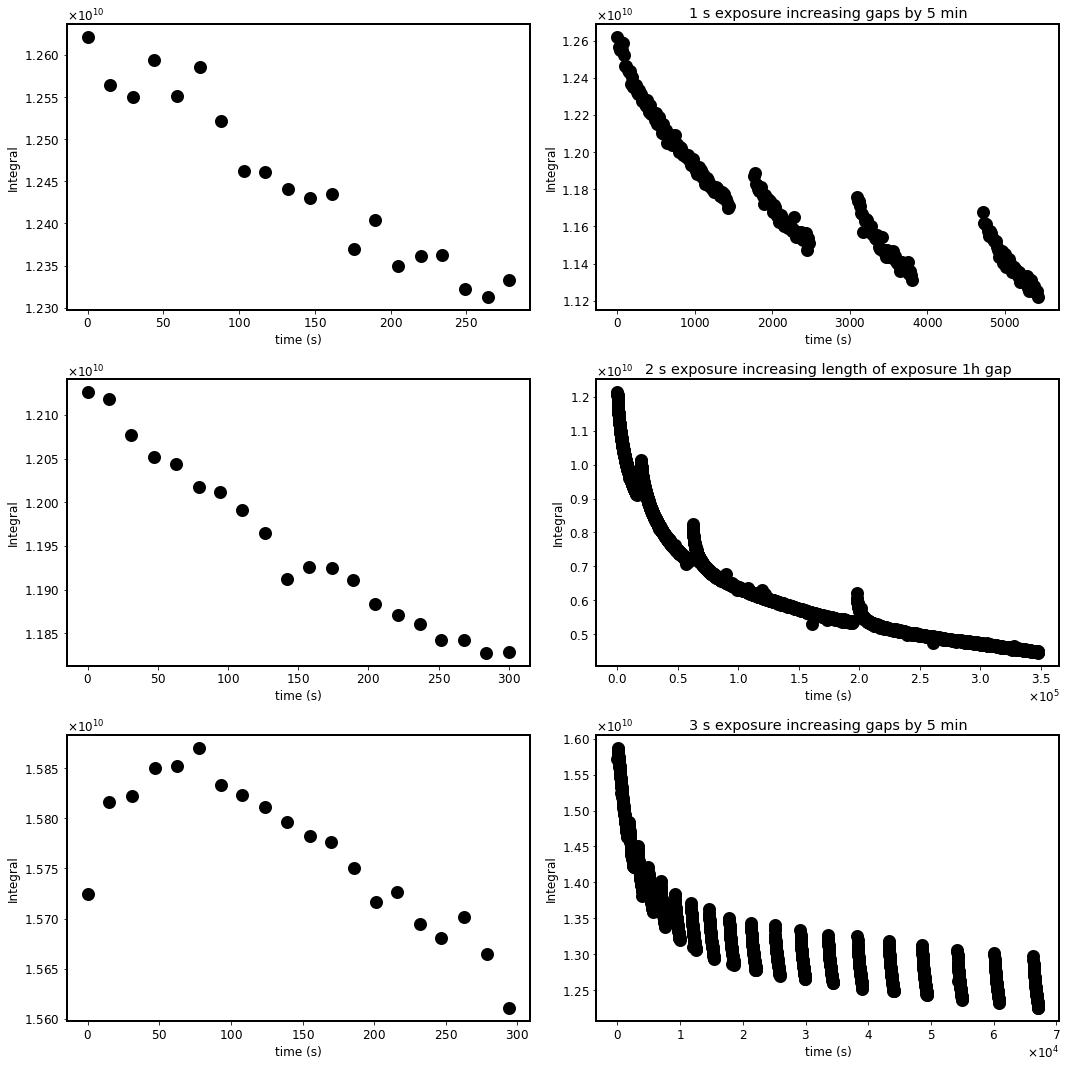

In [10]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
plt.scatter(times_1s[:20], integrals_1s[:20])
plt.xlabel("time (s)")
plt.ylabel("Integral")

plt.subplot(3, 2, 2)
plt.scatter(times_1s, integrals_1s)
plt.xlabel("time (s)")
plt.ylabel("Integral")
plt.title ("1 s exposure increasing gaps by 5 min")

plt.subplot(3, 2, 3)
plt.scatter(times_2s[:20], integrals_2s[:20])
plt.xlabel("time (s)")
plt.ylabel("Integral")


plt.subplot(3, 2, 4)
plt.scatter(times_2s, integrals_2s)
plt.xlabel("time (s)")
plt.ylabel("Integral")
plt.title ("2 s exposure increasing length of exposure 1h gap")

plt.subplot(3, 2, 5)
plt.scatter(times_3s[:20], integrals_3s[:20])
plt.xlabel("time (s)")
plt.ylabel("Integral")

plt.subplot(3, 2, 6)
plt.scatter(times_3s, integrals_3s)
plt.xlabel("time (s)")
plt.ylabel("Integral")
plt.title ("3 s exposure increasing gaps by 5 min")

plt.tight_layout()

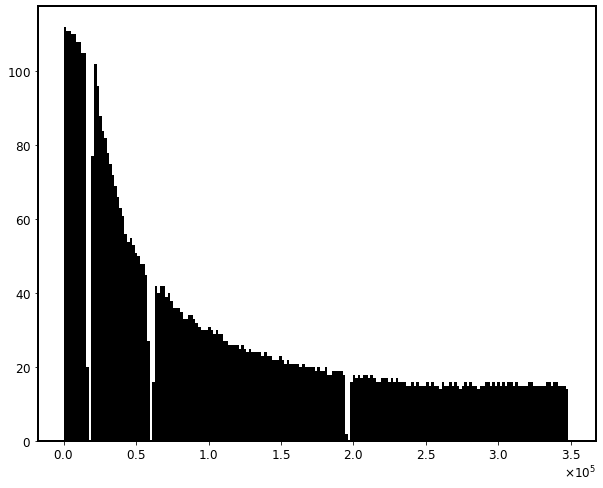

In [9]:
plt.hist(times_2s, np.linspace(0, 3.5e5, 201));

In [11]:
plt.plot(np.diff(integrals_2s));